## __Insight Creation against a PostgreSQL Database containing Customer, Employee, Product and Order Information__

#### _First steps, import the modules used and define our scope by looking at our dataset and thinking of potential useful insights:_

In [1]:
import psycopg2
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import getpass  # to hide the database password
from IPython.display import HTML

For this project I created a PostgreSQL database on my local machine. This database is a fictional database orginally created by Microsoft that contains the sales data for a fictitious company called “Northwind Traders,” which imports and exports specialty foods from around the world.

It contains the following entity relationship diagram:

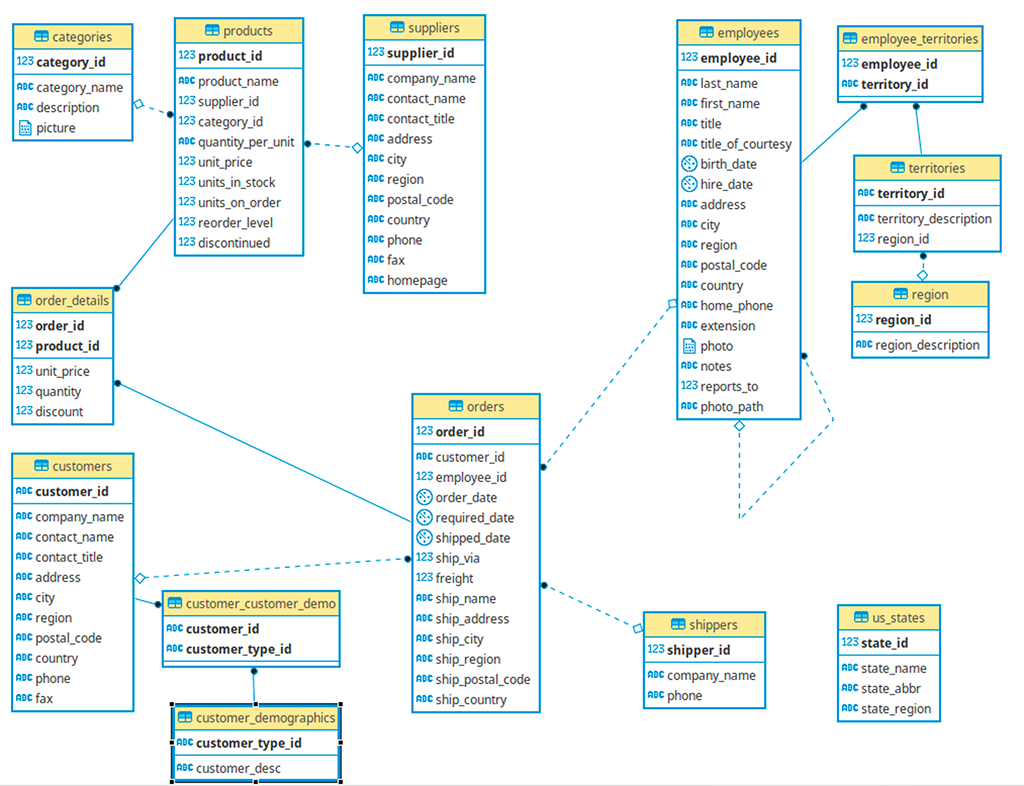

In [2]:
Image(filename = "ER.png", width=1000, height=1000)

The northwind database covers 14 tables and includes data for the following:

- Suppliers: Company names and contact information. Linked to products.

- Products: Product names, # per unit, stock levels, order levels. Linked to the categories and order_details tables.

- Orders: Customer information relating to who ordered what, the price and quantity, where it was shipped to, who shipped it. This is a link between multiple tables.

- Employees: Linked to our order information we have our employees who have employee names and personal information, contact information, reporting lines and working _patch_ or territory.

With the beauty of SQL we can link all this information together how we see fit to return usable insights for our fictional company.



In [3]:
pwd = getpass.getpass(prompt='Password for database:')

In [4]:
def query_postgres_return_dataframe(query       
):
    """This function takes a query to our database
    and returns a dataframe. 
    First it opens our database connection.
    Executes our query and creates a dataframe with it (headers incl.).
    And then closes the connection 
    before returning our dataframe.
    """
    
    conn = psycopg2.connect(
        host="localhost",
        database="northwind",
        user="postgres",
        password= pwd,
        port = 5432)
    cur = conn.cursor()
    cur.execute(query)
    df = pd.DataFrame(cur.fetchall())
    df.columns=[x.name for x in cur.description] 
    conn.commit()
    conn.close()
    return df

First let's see what kind of data range we are dealing with:

In [5]:
query_to_return_min_max_date = """
SELECT 
  MIN(order_date) as min_order_date,
  MAX(order_date) as max_order_date
FROM 
  orders;
"""

max_min_date = query_postgres_return_dataframe(query_to_return_min_max_date)
print(max_min_date)

  min_order_date max_order_date
0     1996-07-04     1998-05-06


__For our analysis let's pretend we have been asked to only look at this year (1998)__

However, if for whatever reason we wanted to look at another year, say 1996 or 1997, change this variable below.

In [6]:
year_of_investigation = 1998

***
### Employee and Region Performance

To begin our analysis let's look at employee performance. We will return our top performing salespeople by total and average revenue. We will then dive into regions and top performing regions.

In [7]:
window_function_average_and_total_revenue_each_employee = f"""
WITH total_revenue_each_employee AS (
  SELECT 
    e.employee_id,
    (e.first_name || ' ' || e.last_name) AS employee_name,
    ROUND(
      SUM(
        od.unit_price :: numeric * od.quantity :: numeric * (1 - od.discount :: numeric)
      ), 
      2
    ) AS total_revenue, 
    count(*) AS number_of_sales, 
    ROUND(
      AVG(
        od.unit_price :: numeric * od.quantity :: numeric * (1 - od.discount :: numeric)
      ), 
      2
    ) AS average_revenue 
  FROM 
    employees e 
    INNER JOIN orders o ON e.employee_id = o.employee_id 
    INNER JOIN order_details od ON o.order_id = od.order_id 
  WHERE 
    EXTRACT(
      YEAR 
      FROM 
        o.order_date
    ) = {year_of_investigation} 
  GROUP BY 
    e.employee_id,
    (e.first_name || ' ' || e.last_name)
)
"""

In [8]:
query_to_return_employees_ranked_by_average_revenue = window_function_average_and_total_revenue_each_employee + """
SELECT
  RANK() OVER(
    ORDER BY 
      average_revenue DESC
  ), 
  employee_name,
  employee_id, 
  average_revenue,
  number_of_sales
FROM 
  total_revenue_each_employee;
  """

In [9]:
employee_rank_based_on_average_revenue = query_postgres_return_dataframe(query_to_return_employees_ranked_by_average_revenue)

print(employee_rank_based_on_average_revenue)

   rank     employee_name  employee_id average_revenue  number_of_sales
0     1    Anne Dodsworth            9          893.55               46
1     2   Janet Leverling            3          814.50               94
2     3       Robert King            7          814.41               60
3     4     Andrew Fuller            2          750.87               99
4     5    Laura Callahan            8          558.50               87
5     6   Steven Buchanan            5          532.21               37
6     7     Nancy Davolio            1          531.05              119
7     8  Margaret Peacock            4          515.58              105
8     9    Michael Suyama            6          321.46               44


In [10]:
query_to_return_employees_ranked_by_total_revenue = window_function_average_and_total_revenue_each_employee + """
    SELECT DISTINCT 
    RANK() OVER( 
      ORDER BY 
        itr.total_revenue DESC
    ), 
    ir.region_description, 
    itr.employee_name,
    itr.total_revenue,
    itr.number_of_sales 
  FROM 
    total_revenue_each_employee itr 
  INNER JOIN (
    SELECT 
      employee_id, 
      territory_id 
    FROM 
      (
        SELECT 
          employee_id, 
          territory_id, 
          ROW_NUMBER() OVER (PARTITION BY employee_id) AS row_num 
        FROM 
          employee_territories 
        ORDER BY 
          territory_id
      ) AS ranked 
    WHERE 
      row_num = 1
  ) iet ON itr.employee_id = iet.employee_id 
    INNER JOIN territories it ON iet.territory_id = it.territory_id 
    INNER JOIN region ir ON it.region_id = ir.region_id 
  ORDER BY 
    RANK() OVER( 
      ORDER BY 
        itr.total_revenue DESC
    ) 
    """

In [11]:
employee_rank_based_on_total_revenue = query_postgres_return_dataframe(query_to_return_employees_ranked_by_total_revenue)

print(employee_rank_based_on_total_revenue)

   rank region_description     employee_name total_revenue  number_of_sales
0     1           Southern   Janet Leverling      76562.73               94
1     2            Eastern     Andrew Fuller      74336.56               99
2     3            Eastern     Nancy Davolio      63195.01              119
3     4            Eastern  Margaret Peacock      54135.94              105
4     5            Western       Robert King      48864.88               60
5     6           Northern    Laura Callahan      48589.54               87
6     7           Northern    Anne Dodsworth      41103.16               46
7     8            Eastern   Steven Buchanan      19691.90               37
8     9            Western    Michael Suyama      14144.16               44


For our analysis total revenue per employee is the more powerful indicator of performance so we will concentrate on that now.

We will now find the highest performing areas and link to the highest performing (revenue generating) employee per area. 

In [12]:
highest_revenue_earner_per_region = window_function_average_and_total_revenue_each_employee + """
SELECT 
    DISTINCT ir.region_description, 
    itr.employee_name,
    itr.employee_id,
    DENSE_RANK() OVER(
      PARTITION BY region_description 
      ORDER BY 
        itr.total_revenue DESC
    ), 
    itr.total_revenue 
  FROM 
    total_revenue_each_employee itr 
    INNER JOIN employee_territories iet ON itr.employee_id = iet.employee_id 
    INNER JOIN territories it ON iet.territory_id = it.territory_id 
    INNER JOIN region ir ON it.region_id = ir.region_id 
  ORDER BY 
    DENSE_RANK() OVER(
      PARTITION BY region_description 
      ORDER BY 
        itr.total_revenue DESC
    ) ASC 
  LIMIT 
    4
;
  """

In [13]:
highest_performing_salesperson_per_region = query_postgres_return_dataframe(highest_revenue_earner_per_region)

print(highest_performing_salesperson_per_region)

  region_description    employee_name  employee_id  dense_rank total_revenue
0            Eastern    Andrew Fuller            2           1      74336.56
1           Northern   Laura Callahan            8           1      48589.54
2           Southern  Janet Leverling            3           1      76562.73
3            Western      Robert King            7           1      48864.88


In [14]:
query_to_return_total_revenue_per_region = window_function_average_and_total_revenue_each_employee + """
SELECT 
  DISTINCT DENSE_RANK() OVER(
    ORDER BY 
      SUM(itr.total_revenue) DESC
  ), 
  ir.region_description, 
  SUM(itr.total_revenue) AS total_revenue_per_region
FROM 
  total_revenue_each_employee itr 
  INNER JOIN (
    SELECT 
      employee_id, 
      territory_id 
    FROM 
      (
        SELECT 
          employee_id, 
          territory_id, 
          ROW_NUMBER() OVER (PARTITION BY employee_id) AS row_num 
        FROM 
          employee_territories 
        ORDER BY 
          territory_id
      ) AS ranked -- complex join necessary due to one-to-many relationship between territory and region.
    WHERE 
      row_num = 1
  ) iet ON itr.employee_id = iet.employee_id 
  INNER JOIN territories it ON iet.territory_id = it.territory_id 
  INNER JOIN region ir ON it.region_id = ir.region_id 
GROUP BY 
  ir.region_description 
ORDER BY 
  DENSE_RANK() OVER(
    ORDER BY 
      SUM(itr.total_revenue) DESC
  ) ASC;

  """

In [15]:
total_revenue_per_region = query_postgres_return_dataframe(query_to_return_total_revenue_per_region)

print(total_revenue_per_region)

   dense_rank region_description total_revenue_per_region
0           1            Eastern                211359.41
1           2           Northern                 89692.70
2           3           Southern                 76562.73
3           4            Western                 63009.04


In [16]:
query_to_return_average_revenue_per_region = window_function_average_and_total_revenue_each_employee + """
SELECT 
  DISTINCT DENSE_RANK() OVER(
    ORDER BY 
      AVG(itr.average_revenue) DESC
  ), 
  ir.region_description, 
  ROUND(AVG(itr.average_revenue),2) AS average_revenue_per_order
FROM 
  total_revenue_each_employee itr 
  INNER JOIN (
    SELECT 
      employee_id, 
      territory_id 
    FROM 
      (
        SELECT 
          employee_id, 
          territory_id, 
          ROW_NUMBER() OVER (PARTITION BY employee_id) AS row_num 
        FROM 
          employee_territories 
        ORDER BY 
          territory_id
      ) AS ranked 
    WHERE 
      row_num = 1
  ) iet ON itr.employee_id = iet.employee_id 
  INNER JOIN territories it ON iet.territory_id = it.territory_id 
  INNER JOIN region ir ON it.region_id = ir.region_id 
GROUP BY 
  ir.region_description 
ORDER BY 
  DENSE_RANK() OVER(
    ORDER BY 
      AVG(itr.average_revenue) DESC
  ) ASC;

  """

In [17]:
average_revenue_per_region = query_postgres_return_dataframe(query_to_return_average_revenue_per_region)

print(average_revenue_per_region)

   dense_rank region_description average_revenue_per_order
0           1           Southern                    814.50
1           2           Northern                    726.03
2           3            Eastern                    582.43
3           4            Western                    567.94


In [18]:
total_revenue_per_region

,dense_rank,region_description,total_revenue_per_region
0,1,Eastern,211359.41
1,2,Northern,89692.70
2,3,Southern,76562.73
3,4,Western,63009.04


In [19]:
highest_performing_region_with_employee = total_revenue_per_region.merge(average_revenue_per_region, on='region_description').merge(highest_performing_salesperson_per_region, on='region_description')

In [20]:
highest_performing_region_with_employee = highest_performing_region_with_employee.rename(columns=
                    {'region_description': 'Region',
                   'total_revenue_per_region': 'Total Revenue of Region',
                   'dense_rank_x': 'Rank of Total Revenue',
                   'average_revenue_per_order': 'Average Revenue per Order',
                    'employee_name': 'Top Salesperson',
                    'total_revenue': 'Total  Revenue of Top Salesperson'}).drop(['employee_id','dense_rank_y', 'dense_rank'], axis=1)


employee_rank_based_on_total_revenue = employee_rank_based_on_total_revenue.rename(columns=
                    {'rank': 'Rank',
                   'total_revenue': 'Total Revenue',
                   'rank': 'Rank of Total Revenue',
                    'employee_name': 'Top Salesperson',
                    'employee_id': 'ID of Salesperson',
                    'number_of_sales': 'Number of Sales'})

In [21]:
HTML(highest_performing_region_with_employee.to_html(index=False))

Rank of Total Revenue,Region,Total Revenue of Region,Average Revenue per Order,Top Salesperson,Total Revenue of Top Salesperson
1,Eastern,211359.41,582.43,Andrew Fuller,74336.56
2,Northern,89692.70,726.03,Laura Callahan,48589.54
3,Southern,76562.73,814.50,Janet Leverling,76562.73
4,Western,63009.04,567.94,Robert King,48864.88


In [22]:
HTML(employee_rank_based_on_total_revenue.to_html(index=False))

Rank of Total Revenue,region_description,Top Salesperson,Total Revenue,Number of Sales
1,Southern,Janet Leverling,76562.73,94
2,Eastern,Andrew Fuller,74336.56,99
3,Eastern,Nancy Davolio,63195.01,119
4,Eastern,Margaret Peacock,54135.94,105
5,Western,Robert King,48864.88,60
6,Northern,Laura Callahan,48589.54,87
7,Northern,Anne Dodsworth,41103.16,46
8,Eastern,Steven Buchanan,19691.90,37
9,Western,Michael Suyama,14144.16,44


Some suggestions from our data could be

High performers - recognition, rewards, cross functional collaboration with other high performers as well as mentoring for low performers.

Low performers - root cause analysis, goal setting, mentorship, training and PIPs.

Region Eastern
- Salesperson performance is good apart from Steve Buchanan. Explore reasons why and get mentorship from high performers such as Andrew Fuller or Nancy Davolio. This will also empower.
- Average sale is the second lowest suggesting that region is already saturated.


Region Southern
- Highest performer is also the only salesperson for this region.
- Average sale is the highest. Potential for re-distribution of Salespeople from Region Eastern to Region Southern after further analysis of market.


Region Western
- Total revenues are low. Salesperson performance is low. Requires further analysis and action.

***
### Identifying High-Value Customers

We define a high-value customer as a customer who has a total revenue __equal to or above the 80th percentile of all customers.__

We will calculate the overall high-value customers now.

In [23]:
window_function_total_revenue_per_customer = f"""
WITH order_value_with_customer_detail AS (
SELECT c.customer_id, c.company_name, c.country, 
  ROUND(
    SUM(
      od.unit_price :: numeric * od.quantity :: numeric * (1 - od.discount :: numeric)
    ) OVER (PARTITION BY o.customer_id), 
    2
  ) AS total_revenue
FROM 
  orders o 
  JOIN order_details od ON o.order_id = od.order_id 
  JOIN customers c on o.customer_id = c.customer_id 
WHERE 
  EXTRACT(
    YEAR 
    FROM 
      o.order_date
  ) = {year_of_investigation}
)
"""

In [24]:
query_high_value_customers_by_revenue = window_function_total_revenue_per_customer + """
SELECT 
  DISTINCT DENSE_RANK() OVER(
    ORDER BY 
      total_revenue DESC
  ), 
  customer_id, 
  company_name, 
  country, 
  total_revenue 
FROM 
  order_value_with_customer_detail 
WHERE 
  total_revenue >= (
    SELECT 
      PERCENTILE_CONT(0.8) WITHIN GROUP (
        ORDER BY 
          total_revenue DESC
      ) 
    FROM 
      order_value_with_customer_detail
  ) 
ORDER BY 
  total_revenue DESC;
"""

In [25]:
top_20_percent_customers_by_revenue = query_postgres_return_dataframe(query_high_value_customers_by_revenue)

top_20_percent_customers_by_revenue = top_20_percent_customers_by_revenue.rename(columns=
                    {'dense_rank': 'Rank of Total Revenue',
                   'total_revenue': 'Total Revenue',
                    'company_name': 'Company Name',
                    'country': 'Country',
                    'customer_id': 'Customer ID'})

HTML(top_20_percent_customers_by_revenue.to_html(index=False))

Rank of Total Revenue,Customer ID,Company Name,Country,Total Revenue
1,ERNSH,Ernst Handel,Austria,41210.65
2,QUICK,QUICK-Stop,Germany,37217.32
3,SAVEA,Save-a-lot Markets,USA,36310.11
4,HANAR,Hanari Carnes,Brazil,23821.20
5,RATTC,Rattlesnake Canyon Grocery,USA,21238.27
6,HUNGO,Hungry Owl All-Night Grocers,Ireland,20402.12
7,KOENE,Königlich Essen,Germany,19582.77
8,WHITC,White Clover Markets,USA,15278.90
9,FOLKO,Folk och fä HB,Sweden,13644.07
10,SUPRD,Suprêmes délices,Belgium,11644.60


The above customers are in our top 80th percentile of customers by revenue in 1998.

We could direct further efforts such as personalised communications, offers, discounts and support to improve and retain their business.

***
### Product Analysis

We define a high-performing product as a product that has a total revenue __equal to or above the 80th percentile of all products.__

We define a high-growth product as a product that has had growth __in all months with sales in 1998.__

_We have excluded the month of May from our growth calculations as our data range is not complete for May._


In [26]:
window_function_product_analysis = f"""
WITH order_value_with_customer_detail AS (
  SELECT 
    p.product_id, 
    od.unit_price, 
    od.quantity, 
    ROUND(
      od.unit_price :: numeric * od.quantity :: numeric, 
      2
    ) AS revenue, 
    o.order_date 
  FROM 
    products p 
    JOIN order_details od ON p.product_id = od.product_id 
    JOIN orders o ON od.order_id = o.order_id 
  WHERE 
    EXTRACT(
      YEAR 
      FROM 
        o.order_date
    ) = {year_of_investigation}
), 
product_performance AS (
  SELECT 
    product_id, 
    SUM(quantity) AS total_order_quantity, 
    SUM(revenue) AS total_revenue 
  FROM 
    order_value_with_customer_detail 
  GROUP BY 
    product_id
), 
monthly_performance AS (
  SELECT 
    product_id, 
    EXTRACT(
      MONTH 
      FROM 
        order_date
    ) AS order_month, 
    SUM(quantity) AS monthly_order_amount 
  FROM 
    order_value_with_customer_detail 
  GROUP BY 
    product_id, 
    EXTRACT(
      MONTH 
      FROM 
        order_date
    )
)
"""

In [27]:
query_products_by_total_revenue = window_function_product_analysis + """
SELECT 
  RANK() OVER(
    ORDER BY 
      total_revenue DESC
  ), 
  product_id, 
  total_order_quantity, 
  total_revenue 
FROM 
  product_performance
WHERE 
  total_revenue >= (
    SELECT 
      PERCENTILE_CONT(0.8) WITHIN GROUP (
        ORDER BY 
          total_revenue DESC
      ) 
    FROM 
      product_performance
  ) 
"""

In [28]:
products_ranked_by_total_revenue = query_postgres_return_dataframe(query_products_by_total_revenue)

products_ranked_by_total_revenue = products_ranked_by_total_revenue.rename(columns=
                    {'rank': 'Rank of Total Revenue',
                   'total_revenue': 'Total Revenue',
                    'total_order_quantity': 'Total Order Quantity',
                    'product_id': 'Product ID'})

HTML(products_ranked_by_total_revenue.to_html(index=False))

Rank of Total Revenue,Product ID,Total Order Quantity,Total Revenue
1,38,260,68510.00
2,29,318,39365.22
3,59,513,28215.00
4,60,542,18428.00
5,62,351,17304.30
6,7,414,12420.00
7,51,222,11766.00
8,64,335,11138.75
9,10,311,9641.00
10,18,151,9437.50


The above products are in our top 80th percentile of products by revenue in 1998.

We could direct further efforts such as inventory management, optimising our supply chain (cheaper suppliers) and diversification.

In [29]:
query_products_by_total_revenue_per_month = window_function_product_analysis + """
SELECT 
  product_id, 
  order_month, 
  monthly_order_amount, 
  ROUND((
    monthly_order_amount - LAG(monthly_order_amount, 1, 0.0) OVER (
      PARTITION BY product_id 
      ORDER BY 
        order_month
    )
  ) / LAG(monthly_order_amount, 1) OVER (
    PARTITION BY product_id 
    ORDER BY 
      order_month
  ) * 100,2) AS percentage_change
FROM 
  monthly_performance 
ORDER BY 
  product_id, 
  order_month;

"""

In [30]:
products_total_revenue_per_month = query_postgres_return_dataframe(query_products_by_total_revenue_per_month)
months_to_remove = [1,5] #January (no percentage change) May (incomplete month)
products_total_revenue_per_month_filtered = products_total_revenue_per_month[~products_total_revenue_per_month['order_month'].isin(months_to_remove)]
products_total_revenue_per_month_filtered['percentage_change'] = products_total_revenue_per_month_filtered['percentage_change'].fillna(-1).astype('float')

In [31]:
def check_positive_percentage_change(data):
    data.sort_values(['product_id', 'order_month'], inplace=True)
    # Create a boolean mask indicating if all percentage_change values are positive per product_id
    positive_mask = data.groupby('product_id')['percentage_change'].transform(lambda x: (x > 0).all())

    # Filter unique product_id where all percentage_change values are positive
    products_with_positive_percentage_change = data.loc[positive_mask, 'product_id'].unique()
    return products_with_positive_percentage_change

In [32]:
positive_products = check_positive_percentage_change(products_total_revenue_per_month_filtered)

In [33]:
filtered_df = products_total_revenue_per_month[products_total_revenue_per_month['product_id'].isin(positive_products)]
filtered_df['product_id'] = filtered_df['product_id'].astype(str)

In [34]:
filtered_df = filtered_df.rename(columns=
                    {'order_month': 'Order Month',
                   'percentage_change': 'Monthly Percentage Change',
                    'monthly_order_amount': 'Monthly Order Quantity',
                    'product_id': 'Product ID'})
HTML(filtered_df.to_html(index=False))

Product ID,Order Month,Monthly Order Quantity,Monthly Percentage Change
6,1,6,None
6,2,50,733.33
6,3,88,76.00
6,5,21,-76.14
16,1,50,None
16,2,63,26.00
16,3,173,174.60
16,5,49,-71.68
27,1,10,None
27,3,55,450.00


Our table below shows the products in our product list that have had positive growth over all the months where there have been sales. For all you will see a negative growth in May, but this is because our data set only contains orders until the 6th of May. We can track this data to ensure we are still on track to grow in May.. .

These products should be given special consideration when thinking about stock and marketing efforts.